# Hackathon 2022

Hier werden Sie ein neuronales Netzwerk auf den Bilddaten trainieren und testen. Stellen Sie Fragen und versuchen Sie, ein tieferes Verständnis von Faltungsnetzen und Pytorch zu entwickeln.
Wir nutzen das Pytorch Framework. Die Dokumentation finden Sie [HIER](https://pytorch.org/docs/stable/index.html).

In [1]:
"""
Dieser Code kopiert und importiert notwendige Dateien in die virtuelle Maschine von Colab.
"""
import sys, os
if 'google.colab' in sys.modules:
  if os.getcwd() == '/content':
    !git clone 'https://github.com/Criscraft/HackathonDigitaltag2022.git'
    os.chdir('HackathonDigitaltag2022')
  
  from google.colab import output
  output.enable_custom_widget_manager()

In [2]:
import sys
from tqdm import tqdm
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models
from torch import optim
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from models import Network
import utils

# best for Jupyter Notebook
#%matplotlib notebook 
# best for Visual Studio Code
#%matplotlib widget 
# best for Google Colab
%matplotlib inline

# Konstanten
GROUPNAME = "mygroupname"
DATA_TRAIN = 'data/train/'
DATA_VAL = 'data/val/'
DATA_TEST = 'data/test/'
MAX_EPOCH = 50
BATCH_SIZE = 64
TRAIN_LOG_PATH = 'train_log.dat'
VAL_LOG_PATH = 'test_log.dat'
NO_CUDA = False
MODEL_FILE_NAME = 'saved_model.pt'

## 1. Vorbereitung des Netzwerks

Ein neues Netzwerk wird erstellt und auf die CPU oder die GPU transferiert. Die Fehlerfunktion ```nn.CrossEntropyLoss()``` und der Optimierer (etwa ```torch.optim.SGD```) werden gewählt. Die Parameter des Modells ```model.parameters()``` werden dem Optimierer zur Verfügung gestellt. Der Optimierer wird nur diese Parameter modifizieren, um die Fehlerfunktion zu minimieren.

In [3]:
use_cuda = not NO_CUDA and torch.cuda.is_available()
cuda_args = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}

#Das Pytorch Device regelt, ob 'cpu' oder 'cuda' (also die GPU) genutzt wird
device = torch.device("cuda") if use_cuda else torch.device("cpu")

#Netzwerk erstellen und auf das Device transferieren
model = Network()
model = model.to(device)

# Fehlerfunktion erstellen
criterion = nn.CrossEntropyLoss()

# Optimierer (stochastic gradient descent) erstellen
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

## 2. Vorbereitung der Daten

Die Trainings- und Validierungsdaten werden durch die Dataset Klasse geladen. Der Dataloader zieht Bilder aus dem Dataset und fügt sie zu Batches zusammen. Die Transformationen ```transforms.Resize```, ```transforms.ToTensor``` und ```transforms.Normalize``` werden mittels ```transforms.Compose``` zu einer Transformation zusammen gefügt. Die Transformation wird auf jedes zu ladende Bild angewendet.

In [4]:
#Die Transformation formt das Eingabebild in einen Tensor um und normalisiert diesen.
norm_mean = (0.485, 0.456, 0.406) # ImageNet mean color
norm_std = (0.229, 0.224, 0.225) # ImageNet standard deviation

transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=norm_mean, std=norm_std),
    ])

#Trainigsdatensatz
trainset = ImageFolder(DATA_TRAIN, transform=transformations)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

#Validierungsdatensatz
valset = ImageFolder(DATA_VAL, transform=transformations)
val_loader = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE)

#Testdatensatz
testset = ImageFolder(DATA_TEST, transform=transformations)
test_loader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The labels of the dataset are:
['Tomato_Septoria_leaf_spot', 'Tomato_Tomato_Yellow_Leaf_Curl_Virus', 'Tomato_healthy']


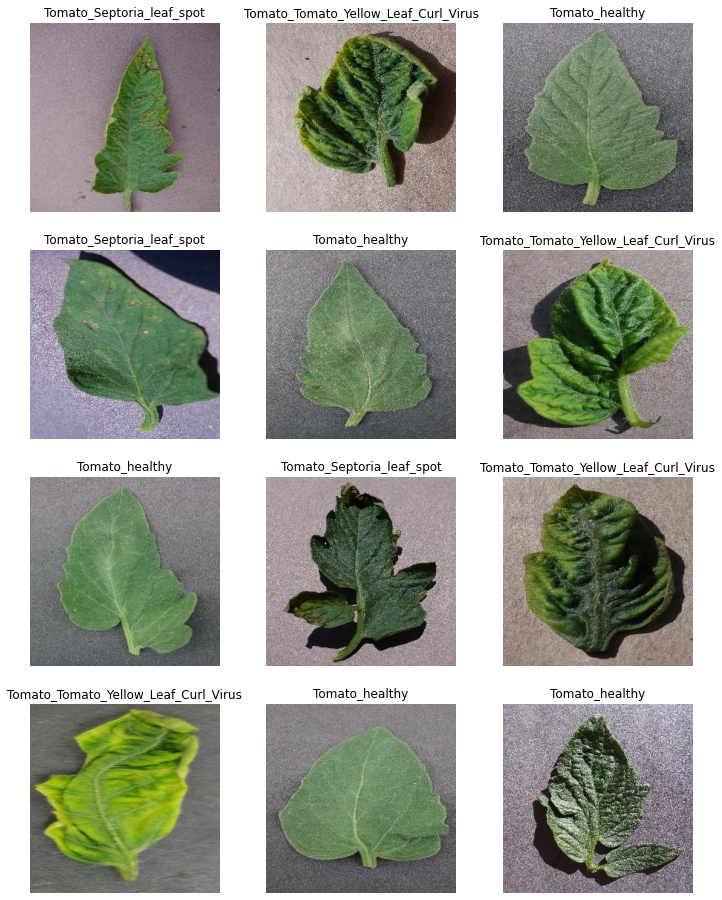

In [5]:
""" Plotten von einigen Trainingsbildern """
print("The labels of the dataset are:")
print(trainset.classes)
indices = np.random.randint(0, len(trainset), 12)
plotted_images = [trainset[index][0].numpy() for index in indices]
plotted_labels = [trainset.classes[trainset[index][1]] for index in indices]
fig = utils.plot_images(plotted_images, plotted_labels, norm_mean=norm_mean, norm_std=norm_std)

## 3. Training und Validierung

Die nächste Codezelle implementiert die Trainingsschleife, in der die Parameter des Netzwerks iterativ verbessert werden. Lassen Sie sich Zeit, den Ablauf genau zu verstehen. Der Code tut folgendes:

1. Mithilfe der Funktionen ```utils.init_log``` eine Logdatei für die Trainingsergebnisse erzeugen - einmal für die Trainingsdaten und noch einmal für die Validierungsdaten
2. In einer for-Schleife über die Epochen iterieren. Nutzen Sie die Funktion tqdm, um einen Ladebalken darzustellen.
3. In einer Schleife über die Minibatches der Trainingsdaten iterieren, mit den Minibatches einen Forward Pass durchführen, den Fehler berechnen und die Parameter des Netzwerkes bei einem Optimierungsschritt anpassen
4. Den aktuellen Fehler und die Genauigkeit auf den Trainingsdaten in die Logdatei schreiben mit ```utils.write_log```.
5. In einer Schleife über die Minibatches der Validierungsdaten iterieren, mit den Minibatches einen Forward Pass durchführen und den Fehler berechnen.
6. Den aktuellen Fehler und die Genauigkeit auf den Validierungsdaten in die Logdatei schreiben.
7. Wenn MAX_EPOCH erreicht ist und das Training beendet ist, das Netzwerk auf der Platte abspeichern. Wir werden Ihr trainiertes Netzwerk morgen noch einmal benötigen!

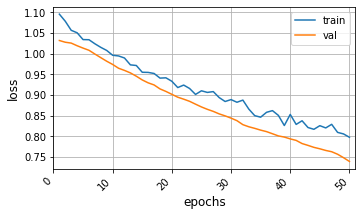

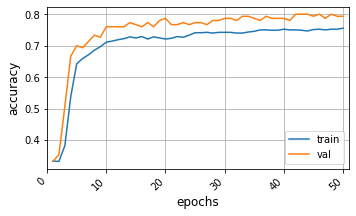

100%|██████████| 50/50 [02:20<00:00,  2.80s/it]


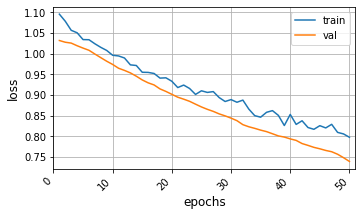

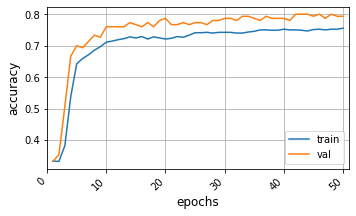

In [6]:
#Die beiden Logdateien werden mit utils.init_log für das Training und das Testen erstellt
utils.init_log(TRAIN_LOG_PATH)
utils.init_log(VAL_LOG_PATH)

# Plotten des mittleren Fehlers
loss_plotter = utils.AnimationPlotter(TRAIN_LOG_PATH, VAL_LOG_PATH, 'loss')
# Plotten der mittleren Genauigkeit
accuracy_plotter = utils.AnimationPlotter(TRAIN_LOG_PATH, VAL_LOG_PATH, 'accuracy')

for epoch in tqdm(range(1, MAX_EPOCH + 1)):
    
    ### Training ###
    
    # Die Listen 'losses' und 'correct' dienen dem Speichern der Zwischenergebnisse.
    losses = []
    correct = []
    n_images = 0
    
    # WICHTIG! Das Netzwerk in den Trainingsmodus umschalten!
    model.train()
    
    for data, target in train_loader:
        # Nebenschleife über die Training Minibatches
        
        n_images += len(target)
        
        # Transferieren von data und target auf das Pytorch Device
        data = data.to(device)
        target = target.to(device)
        
        # Die gespeicherten Gradienten auf 0 setzen
        optimizer.zero_grad()
        
        # Forward Pass
        outputs = model(data)
        
        # Fehler auf dem Batch berechnen
        loss_batch = criterion(outputs, target)

        # vorhergesage Labels bestimmmen und zählen, wie viele Labels korrekt vorausgesagt wurden.
        pred = outputs.argmax(1)
        correct_batch = (target == pred).sum()
        
        # Berechnung des Gradienten
        loss_batch.backward()
        
        # Optimierungsschritt
        optimizer.step()
        
        losses.append(loss_batch.item())
        correct.append(correct_batch.item())
        
    losses = np.array(losses)
    correct = np.array(correct)
    
    # mittleren Fehler und die mittlere Genauigkeit berechnen
    loss = losses.mean()
    accuracy = correct.sum() / n_images
    
    # Speicherung der Zwischenergebnisse
    utils.write_log(TRAIN_LOG_PATH, epoch, loss, accuracy)
    
    ### Validierung ###
    
    losses = []
    correct = []
    n_images = 0
    
    # WICHTIG! Das Netzwerk in den Testmodus umschalten!
    model.eval()
    
    # WICHTIG! Zur Validierung die Berechnung der Gradienten ausstellen!
    with torch.no_grad():
        for data, target in val_loader:
            # Nebenschleife über die Test Minibatches
            
            n_images += len(target)
            
            data = data.to(device)
            target = target.to(device)
            
            outputs = model(data)
            
            loss_batch = criterion(outputs, target)
            
            pred = outputs.argmax(1)
            
            correct_batch = (target == pred).sum()
            
            losses.append(loss_batch.item())
            correct.append(correct_batch.item())
        
    losses = np.array(losses)
    correct = np.array(correct)
    loss = losses.mean()
    accuracy = correct.sum() / n_images
    utils.write_log(VAL_LOG_PATH, epoch, loss, accuracy)

    loss_plotter.update_values()
    accuracy_plotter.update_values()

# Abspeichern des trainierten Netzwerks
torch.save(model.state_dict(), MODEL_FILE_NAME)


In [7]:
""" Apply model on test data """
# WICHTIG! Das Netzwerk in den Testmodus umschalten!
model.eval()

output_list = []

# WICHTIG! Zur Validierung die Berechnung der Gradienten ausstellen!
with torch.no_grad():
    for data, target in test_loader:
        data = data.to(device)
        outputs = model(data)
        output_list.append(outputs.cpu())
logits = torch.cat(output_list).numpy()

submission = pd.DataFrame(logits)
submission.to_csv(GROUPNAME + "_submission.csv")

## 4. Jetzt sind Sie dran!

Hier ein paar Ideen, wie Sie Ihren Algorithmus verbessern können:

- Augmentieren Sie Ihre Trainingsdaten: Bildausschnitte, Skalierung, Kontraständerungen, Weißes Rauschen, Spiegelung, ... was hilft Ihnen bei diesem Problem weiter? Das Paket [torchvision.transforms](https://pytorch.org/vision/0.11/transforms.html) hat einige nützliche Funktionen zu bieten!
- Ändern Sie Ihre Netzwerkarchitektur: Machen Sie das Netzwerk tiefer, flacher, weiter oder schmaler. Wie wirken sich Ihre Modifikationen auf Überanpassung und Genauigkeit aus?
- Modifizieren Sie die Lernrate. Probieren Sie, die Lernrate nach einiger Zeit zu verringern. Gewinnen Sie dadurch an Genauigkeit?
- Benutzen Sie einen anderen Optimierer wie z.B. Adam. [HIER](https://pytorch.org/docs/stable/optim.html) gibt es eine Übersicht verschiedener Optimierer.
- Nutzen Sie Regularisierung: Experimentieren Sie z.B. mit Momentum oder Weight Decay. 
- Nutzen Sie ein vortrainiertes Netzwerk. Schauen Sie sich [HIER](https://pytorch.org/vision/0.11/models.html) das Angebot an vortrainierten Netzwerken an.
- Falls Sie noch nicht genug haben: Trainieren Sie mehrere Netzwerke (nach einander), bündeln Sie sie zu einem Ensemble und nutzen Sie für die Validierung ihre gemittelte Ausgabe. Was müssen Sie bei der Mittelung der Ausgaben beachten?